# リサンプリング法

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.linear_model as skl_lm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score

In [3]:
auto = pd.read_csv('Datasets/Auto.csv', na_values='?').dropna()
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite


In [7]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 交差検証

### ホールドアウト検証

ある観測データについて統計的学習法を当てはめた場合のテスト誤差を推定したいとする。

ホールドアウト検証では、まず観測データをランダムに訓練データと検証データに分割する。モデルは訓練データに当てはめられ、このモデルを使い検証データにおいて応答変数を予測する。ホールドアウト検証誤差の評価としては、応答変数が量的であれば通常MSEが使われるが、これがテスト誤差の推定値となる。

``Auto``データセットをつかってホールドアウト検証を説明する。このデータセットにおける``mpg``と``horsepower``の関係は非線形のようであり、3時やそれ以上の項をつかうことでさらに良い結果が得られるのではないかと考えるのは自然なことである。線形回帰においては高次の項についてのp値を調べることでこれを判断したが同様のことがホールドアウト検証でも判断できる。まず392個のデータを196個の訓練データと196個の検証データに分割する。さまざまな回帰モデルを訓練データにあてはめ、検証データに使った際の性能を表すものとしてホールドアウト検証MSEを計算する。

この結果はデータセットの分割の仕方に依存する（あるデータセットはあるモデル族（線形から10次式まで）と対応し、さらにこれらはあるテストMSEと対応する）ことに注意。つまりデータセットの分割の仕方を変えると、計算しているものも（概念としては同じ「テストMSE」だが）変わる。

### 1つ抜き交差検証（LOOCV: leave-one-out cross-validation）

これはホールドアウト検証に似ているが、その欠点を考慮し改善したものである。ホールドアウト検証ではデータセットを2つの同等の大きさのデータに分割したが、LOOCVは1つのデータ$(x_1, y_1)$のみを検証データとして用いる。残りのデータ$\{(x_2, y_2), \ldots, (x_n, y_n)\}$は訓練データとなる。統計的学習法を$n-1$個の訓練データに当てはめ、取りおきした値$x_1$を用いて予測値$\hat{y}_1$を得る。$(x_1,y_1)$は当てはめる際には使っていないので、$\mathrm{MSE}_1 = (y_1 - \hat{y}_1)^2$は近似的にテスト誤差の不偏推定値となる。しかし、バイアスはないものの、$\mathrm{MSE}_1$はテスト誤差の良い推定値ではない。たった1つのデータ$(x_1, y_1)$によるため、分散が大きいためである。

そこでこの手続きを$n$回繰り返すことにより$n$個の2乗誤差$\mathrm{MSE}_1, \ldots, \mathrm{MSE}_n$を得る。これらの平均をLOOCVにおけるテストMSEの推定値とする：

\begin{equation}
    \mathrm{CV}_{(n)} = \frac{1}{n}\sum_{i=1}^n \mathrm{MSE}_i
\end{equation}

LOOCVはホールドアウト検証に比べていくつかの大きな長所がある。
まずバイアスがかなり小さい。LOOCVでは繰り返し$n-1$個の訓練データを用いで統計的学習法を当てはめる。この$n-1$個のデータは手元にあるデータのほぼすべてである。ホールドアウト検証では通常訓練データはデータ全体の半分程度であるから、これは大きな違いである。結果として、LOOCV誤差はホールドアウト検証ほどばテスト誤差を過大評価しない。
次に、訓練データと検証データをランダムに分割することによりホールドアウト検証では毎回異なる結果を得るが、LOOCVは毎回同じ結果となる。訓練データと検証データに分割する際のランダム性が無いのである。

LOOCVは$n$回モデルを当てはめることになるため、実装するには高い計算量を必要とする可能性があることはLOOCVの欠点である。しかし最小二乗法による線形または多項式回帰では以下の式によりLOOCVをただ1つのモデルを当てはめるのと同じ計算量で行うことができる（$h_i$はてこ比）：
\begin{equation}
    \mathrm{CV}_{(n)} = \frac{1}{n}\sum_{i=1}^n \left( \frac{y_i - \hat{y}_i}{1 - h_i} \right)
\end{equation}

### $k$分割交差検証

$k$分割交差検証においては、観測データをおよそ同じサイズの$k$個のグループまたはブロックに分割する。最初のグループを検証に使い、残りの$k-1$個のグループを使ってモデルを当てはめる。その後平均2乗誤差$\mathrm{MSE}_1$を取りおきしたグループで計算する。これを$k$回繰り返し、毎回異なるグループを検証データとして使用する。結果としてテスト誤差の推定値は$\mathrm{MSE}_1, \ldots, \mathrm{MSE}_k$の$k$個が得られる。これらの平均をとることにより$k$分割交差検証の推定値を求める：

\begin{equation}
    \mathrm{CV}_{(k)} = \frac{1}{k}\sum_i^{k}\mathrm{MSE}_i
\end{equation}

LOOCVは$k$分割交差検証で$k=n$とした特別な場合であることが容易にわかる。

## 図5.2

ホールドアウト検証を``auto``データに適用し、``horsepower``の多項式で``mpg``を予測した時のテスト誤差を推定する。左は訓練データと検証データに分割したときの検証MSE（つまりある分割の仕方でデータセットは分割されている）。右はデータを訓練用と検証用に毎回ランダムに分割し直して、ホールドアウト検証を10回繰り返した。このアプローチにおける検証MSEのばらつきが分かる。また、右から線形モデルはこのデータには適していないことがわかる。

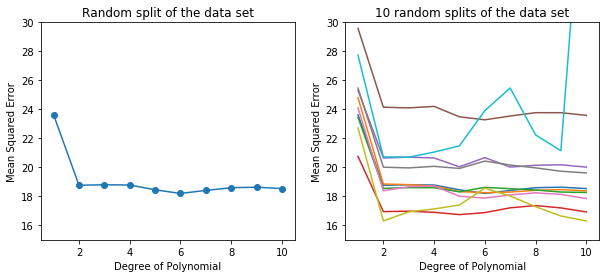

In [71]:
t_prop = 0.5
# 次数
p_order = np.arange(1,11)
# 描きたい曲線の数
r_state = np.arange(0,10)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
# MSEを入れる行列
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# ndenumerate(A)は、Aの、(行番号, 列番号), 値を出力するイテレータ
for (i,j), v in np.ndenumerate(Z):
    # X[i,j] = i+1, 添字iとXの成分から1次式すべて計算→2次式すべて計算→・・・となっていることがわかる
    poly = PolynomialFeatures(int(X[i,j]))
    # reshapeの第1引数が-1のときは「第2引数の長さ」の配列を複数生成する
    # 説明変数ベクトルから計画行列を作成する
    # DataFrame or Seriesのvalues属性でndarrayを取得
    X_poly = poly.fit_transform(auto.horsepower.values.reshape(-1,1))
    
    # test_sizeに少数で検証データの割合を指定する
    # random_stateに乱数生成の種を指定する
    # numpy.ravel()はA.ravel()で一次元配列化するメソッド
    X_train, X_test, y_train, y_test = train_test_split(X_poly, auto.mpg.ravel(), test_size=t_prop, random_state=Y[i,j])
    
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    # i=0,...,0(10個),1,...,1,..., j=0,1,2,...,9,0,1,...つまりまず1行目に1次式のMSEが格納される
    Z[i,j]= mean_squared_error(y_test, pred)
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
# XもZもある色＝ある列
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

## 図5.4

``auto``データセットにおいて``horsepower``の多項式で``mpg``を予測したときのテスト誤差を推定するためにLOOCVを適用した。左はLOOCV誤差曲線であり、右は10分割交差検証を9回行った。毎回データをランダムに10分割した。図は9本の10分割交差検証誤差曲線であり、その違いはわずかである。

In [91]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
# DataFrameを与えて検証回数を取得
loo.get_n_splits(auto)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(auto.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, auto.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

# k-fold CV
folds = 10
elements = len(auto.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(auto.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, random_state=Y[i,j])
    Z[i,j] = cross_val_score(regr, X_poly, auto.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()

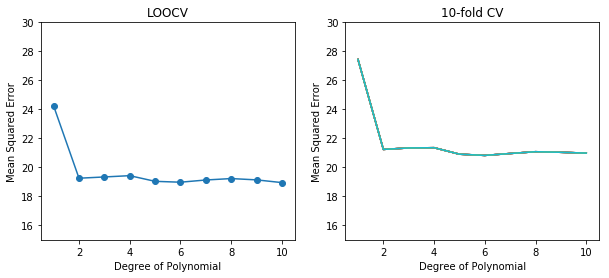

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Note: cross_val_score() method return negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

## Reference

- 落海浩，首藤信通．Rによる統計的学習入門．朝倉書店，2018，403p．
- https://github.com/JWarmenhoven/ISLR-python